In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style = "darkgrid")
%matplotlib inline


from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model


from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import *
from keras import backend


from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import HalvingGridSearchCV
#from sklearn.experimental import enable_halving_search_cv
from hyperopt import STATUS_OK
import lightgbm as lgb
from hyperopt import fmin, tpe, Trials


from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import  mean_squared_error, r2_score,plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,precision_score, recall_score,f1_score, confusion_matrix
from matplotlib import pyplot
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense





In [ ]:
credit_smgrid = pd.read_csv('gdrive/My Drive/Thesis_Research_LJMU/creditcard.csv')
credit_smgrid.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
X = credit_smgrid.drop(['Class'], axis =1)
y = credit_smgrid['Class']

In [ ]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X, y.values.ravel())
#smote_value_counts = y_train_smote["Class"].value_counts()
#print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

y_resample=pd.DataFrame(y_train_smote)
X_resample=pd.DataFrame(X_train_smote)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size = 0.3, random_state=142)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
log_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()


logreg_cv = GridSearchCV(estimator = logreg,param_grid = log_grid, cv=10)
logreg_cv.fit(X_train,y_train)


print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)

tuned hyperparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}


In [ ]:
logreg_cvsm=LogisticRegression(C=1000,penalty="l2")
logreg_cvsm.fit(X_train, y_train)

lr_predsm = logreg_cvsm.predict(X_test)

print("Accuracy {}".format(metrics.accuracy_score(y_test, lr_predsm)))
print("Recall/Sensitivity {}".format(metrics.recall_score(y_test, lr_predsm)))
print(confusion_matrix(y_test, lr_predsm))
print(classification_report(y_test, lr_predsm))

tpr = recall_score(y_test, lr_predsm)
tnr = recall_score(y_test, lr_predsm, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Accuracy 0.9821398764813888
Recall/Sensitivity 0.9814251941911516
[[2978   52]
 [  55 2906]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3030
           1       0.98      0.98      0.98      2961

    accuracy                           0.98      5991
   macro avg       0.98      0.98      0.98      5991
weighted avg       0.98      0.98      0.98      5991

False Positive rate =0.017
True Positive Rate = 0.981
False Negative rate =0.019
True Negative Rate = 0.983


Logistic: ROC AUC=0.998


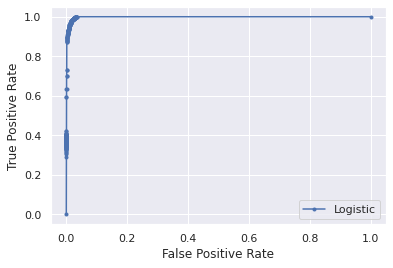

In [ ]:
lr_probsm = logreg_cvsm.predict_proba(X_test)
lr_probsm = lr_probsm[:, 1]


lr_auc = roc_auc_score(y_test, lr_probsm)
print('Logistic: ROC AUC=%.3f' % (lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probsm)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [ ]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto','log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 3)
CV_rfc.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",CV_rfc.best_params_)

tuned hyperparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [ ]:
rf_modelsm = RandomForestClassifier(criterion = 'entropy', max_depth = 8, max_features =  'auto', n_estimators = 500)

rf_modelsm.fit(X_train, y_train)

rf_predsm = rf_modelsm.predict(X_test)

print("Accuracy {}".format(metrics.accuracy_score(y_test, rf_predsm)))
print("Recall/Sensitivity {}".format(metrics.recall_score(y_test, rf_predsm)))
print(confusion_matrix(y_test,rf_predsm))
print(classification_report(y_test, rf_predsm))

tpr = recall_score(y_test, rf_predsm)
tnr = recall_score(y_test, rf_predsm, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Accuracy 0.99949924887331
Recall/Sensitivity 0.9993245525160419
[[3029    1]
 [   2 2959]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      2961

    accuracy                           1.00      5991
   macro avg       1.00      1.00      1.00      5991
weighted avg       1.00      1.00      1.00      5991

False Positive rate =0.000
True Positive Rate = 0.999
False Negative rate =0.001
True Negative Rate = 1.000


Random Forest: ROC AUC=1.000


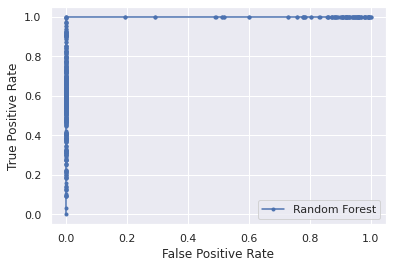

In [ ]:
rf_probsm = rf_modelsm.predict_proba(X_test)
rf_probsm = rf_probsm[:, 1]


rf_auc = roc_auc_score(y_test, rf_probsm)
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probsm)
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [ ]:
xgb_ad = XGBClassifier()

params_xgb = {
    'max_depth': [7, 10, 25],
    'n_estimators': [200, 500],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0.5, 2, 5]
}

CV_xgb = GridSearchCV(estimator = xgb_ad, param_grid = params_xgb , scoring = 'f1', n_jobs=3, cv=3)
CV_xgb.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",CV_xgb.best_params_)

tuned hyperparameters :(best parameters)  {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [ ]:
xgbsm = XGBClassifier(gamma= 0.5, learning_rate= 0.1, max_depth= 10, n_estimators= 200)
xgbsm.fit(X_train, y_train)
xgb_predsm = xgbsm.predict(X_test)

print("Accuracy {}".format(metrics.accuracy_score(y_test, xgb_predsm)))
print("Recall/Sensitivity {}".format(metrics.recall_score(y_test, xgb_predsm)))
print(confusion_matrix(y_test, xgb_predsm))
print(classification_report(y_test, xgb_predsm))


tpr = recall_score(y_test, xgb_predsm)
tnr = recall_score(y_test, xgb_predsm, pos_label = 0)
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Accuracy 0.9991654147888499
Recall/Sensitivity 0.999662276258021
[[3026    4]
 [   1 2960]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      2961

    accuracy                           1.00      5991
   macro avg       1.00      1.00      1.00      5991
weighted avg       1.00      1.00      1.00      5991

False Positive rate =0.001
True Positive Rate = 1.000
False Negative rate =0.000
True Negative Rate = 0.999


XGBoost: ROC AUC=1.000


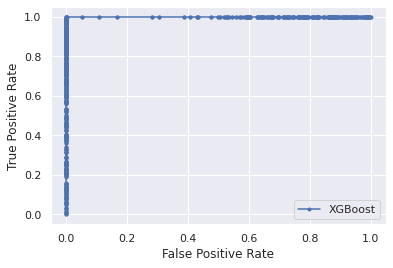

In [ ]:
xgb_probsm = xgbsm.predict_proba(X_test)
xgb_probsm = xgb_probsm[:, 1]


xgb_auc = roc_auc_score(y_test, xgb_probsm)
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probsm)
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [ ]:
gbc_sm = GradientBoostingClassifier()

params = {
    'n_estimators': [400, 700, 1000],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3]
}

CV_gbc = GridSearchCV(estimator = gbc_sm, param_grid=params, scoring='f1', n_jobs= 6, cv= 3)
CV_gbc.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",CV_gbc.best_params_)

tuned hyperparameters :(best parameters)  {'max_depth': 15, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': 1.1}


In [ ]:
lgbsm = GradientBoostingClassifier(max_depth= 15, n_estimators= 400, reg_alpha= 1.1, reg_lambda= 1.1)
lgbsm.fit(X_train, y_train)

lgb_predsm = lgbsm.predict(X_test)

print("Accuracy {}".format(metrics.accuracy_score(y_test, lgb_predsm)))
print("Recall/Sensitivity {}".format(metrics.recall_score(y_test, lgb_predsm)))
print(confusion_matrix(y_test, lgb_predsm))
print(classification_report(y_test, lgb_predsm))


tpr = recall_score(y_test, lgb_predsm)
tnr = recall_score(y_test, lgb_predsm, pos_label = 0)
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Accuracy 1.0
Recall/Sensitivity 1.0
[[3031    0]
 [   0 2960]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3031
           1       1.00      1.00      1.00      2960

    accuracy                           1.00      5991
   macro avg       1.00      1.00      1.00      5991
weighted avg       1.00      1.00      1.00      5991

False Positive rate =0.000
True Positive Rate = 1.000
False Negative rate =0.000
True Negative Rate = 1.000


XGBoost: ROC AUC=1.000


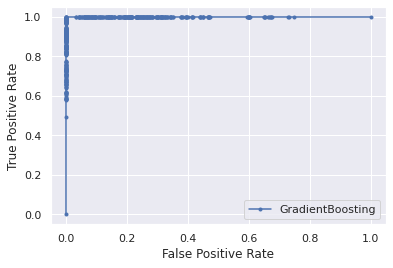

In [ ]:
lgb_probsm = lgbsm.predict_proba(X_test)
lgb_probsm = lgb_probsm[:, 1]


lgb_auc = roc_auc_score(y_test, lgb_probsm)
print('XGBoost: ROC AUC=%.3f' % (lgb_auc))
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_probsm)
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='GradientBoosting')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()